In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jul 29 21:16:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
import re


In [6]:
# Retrive the data from stored dataset
dataDir = "/content/drive/MyDrive/WoS/data"
tsvData = os.path.join(dataDir,"WoSDataset_5736.tsv")

tsvData = np.loadtxt(tsvData, dtype=str, delimiter="\t")
print(np.shape(tsvData))

(5736, 4)


In [7]:
print(tsvData[0:15])

[['2' 'biochemistry'
  ' candidatus phytoplasma    16s rrna biosecurity taxonomy biodiversity vector seed transmission host range       '
  'phytoplasmas are insectvectored bacteria that cause disease in a wide range of plant species the increasing availability of molecular dna analyses expertise and additional methods in recent years has led to a proliferation of discoveries of phytoplasmaplant host associations and in the numbers of taxonomic groupings for phytoplasmas the widespread use of common names based on the diseases with which they are associated as well as separate phenetic and taxonomic systems for classifying phytoplasmas based on variation at the 16s rrnaencoding gene complicates interpretation of the literature we explore this issue and related trends through a focus on australian pathosystems providing the first comprehensive compilation of information for this continent covering the phytoplasmas host plants vectors and diseases of the 33 16sr groups reported internati

In [8]:
allLabels = tsvData[:,0]
domains = tsvData[:,1]
keywords = tsvData[:,2]
abstracts = tsvData[:,3]

In [9]:
labels = np.unique(domains, return_counts=True)[0]
labelCounts=  np.unique(domains, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [1292 1597 2847]


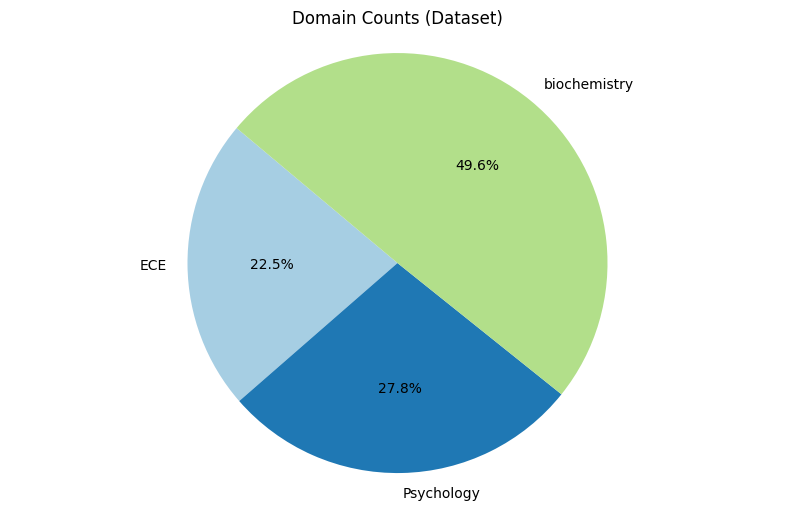

The domain ECE has 1292 records in the dataset.
The domain Psychology has 1597 records in the dataset.
The domain biochemistry has 2847 records in the dataset.


In [10]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the dataset.")

In [11]:
# Shuffle data
dataShuffled = sklearn.utils.shuffle(tsvData)

abstractsShuffled = dataShuffled[:,3]
keywordsShuffled = dataShuffled[:,2]
domainsShuffled = dataShuffled[:,1]
allLabelsShuffled = dataShuffled[:,0]

print("Number of abstracts: ", len(abstractsShuffled))
print("Shape of abstracts: ", np.shape(abstractsShuffled))
print(abstractsShuffled[0:2])

print("Number of keywords: ", len(keywordsShuffled))
print("Shape of keywords: ", np.shape(keywordsShuffled))
print(abstractsShuffled[0:2])

print("Number of domains: ", len(domainsShuffled))
print("Shape of domains: ", np.shape(domainsShuffled))
print(domainsShuffled[0:2])

print("Number of labels: ", len(allLabelsShuffled))
print("Shape of labels: ", np.shape(allLabelsShuffled))
print(allLabelsShuffled[0:2])


# Convert labels to integer
allLabelsDigitShuffled = allLabelsShuffled.astype(int)

print(abstractsShuffled[0:10])
print(keywordsShuffled[0:10])
print(domainsShuffled[0:10])
print(allLabelsShuffled[0:10])
print(allLabelsDigitShuffled[0:10])

Number of abstracts:  5736
Shape of abstracts:  (5736,)
['constantly elevated temperatures cause an array of physiobiochemical changes in tomato lycopersicum esculentum mill which make the fruit ripen quickly and up to 50  yield loss the development of tomato cultivars using genetic engineering approaches which delay ripening offers a new way to keep tomatoes healthy under heat stress overexpression of small heat shock protein gene viscosity 1 vis 1 plays a role in increasing juice viscosity early ripening and tissue soften which emphasizes the importance of this gene in premature ripening the aim of this work was therefore to develop a useful system for silencing the vis1 gene using small interfering rna strategy agrobacterium strain gv3101 harbouring the binary vector picbv19 containing the gus and bar genes was used to adapt the transformation process in this study the primers were designed to amplified the first exon of the vis 1 gene and the amplified fragment was used for cloning

In [12]:
# Split dataset into training and testing (80/20 split)
train_data, test_data = train_test_split(dataShuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

# Further split training data into training and validation (80/20 split of training set)
_, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))
# Load SciBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

(4588, 4)
(1148, 4)
(4588, 4)
(1148, 4)
(230, 4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
abstractsTrain = train_data[:,3]
keywordsTrain = train_data[:,2]
domainsTrain = train_data[:,1]
allLabelsTrain = train_data[:,0]

print("Number of abstracts: ",len(abstractsTrain))
print("Shape of abstracts: ",np.shape(abstractsTrain))
print("Number of keywords: ",len(keywordsTrain))
print("Shape of keywords: ",np.shape(keywordsTrain))
print("Number of domains: ",len(domainsTrain))
print("Shape of domains: ",np.shape(domainsTrain))
print("Number of labels: ",len(allLabelsTrain))
print("Shape of labels: ",np.shape(allLabelsTrain))

print(abstractsTrain[0:2])
print(keywordsTrain[0:2])
print(domainsTrain[0:2])
print(allLabelsTrain[0:2])

Number of abstracts:  4588
Shape of abstracts:  (4588,)
Number of keywords:  4588
Shape of keywords:  (4588,)
Number of domains:  4588
Shape of domains:  (4588,)
Number of labels:  4588
Shape of labels:  (4588,)
['spontaneous epileptiform activity has previously been observed in lateral amygdala la slices derived from patients with intractabletemporal lobe epilepsy the present study aimed to characterize intranuclear la synaptic connectivity and to test the hypothesis that differences in the spread of flow of neuronal activity may relate to spontaneous epileptiform activity occurrence electrical activity was evoked through electrical microstimulation in acute human brain slices containing the la signals were recorded as local field potentials combined with fast optical imaging of voltagesensitive dye fluorescence sites of stimulation and recording were systematically varied following recordings slices were anatomically reconstructed using twodimensional unitary slices as a reference fo

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [1048 1277 2263]


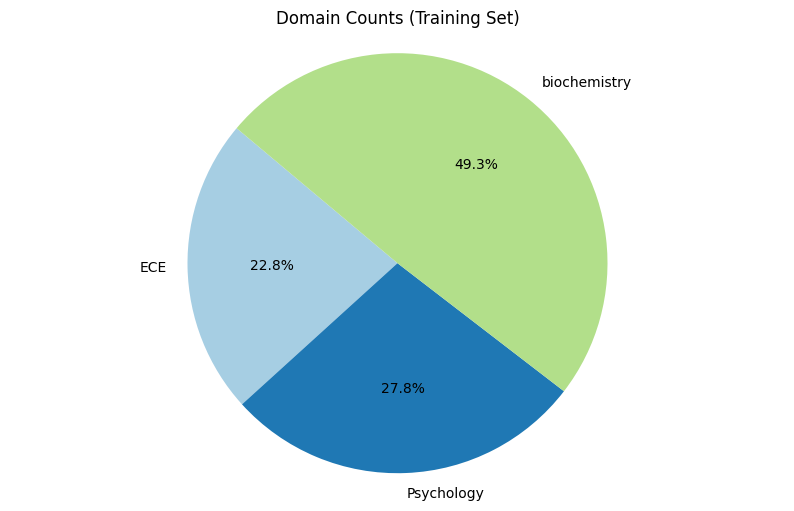

The domain ECE has 1048 records in the training set.
The domain Psychology has 1277 records in the training set.
The domain biochemistry has 2263 records in the training set.


In [14]:
labels = np.unique(domainsTrain, return_counts=True)[0]
labelCounts =  np.unique(domainsTrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTrain)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the training set.")

In [15]:
abstractsTest = test_data[:,3]
keywordsTest = test_data[:,2]
domainsTest = test_data[:,1]
allLabelsTest = test_data[:,0]

print("Number of abstracts: ",len(abstractsTest))
print("Shape of abstracts: ",np.shape(abstractsTest))
print("Number of keywords: ",len(keywordsTest))
print("Shape of keywords: ",np.shape(keywordsTest))
print("Number of domains: ",len(domainsTest))
print("Shape of domains: ",np.shape(domainsTest))
print("Number of labels: ",len(allLabelsTest))
print("Shape of labels: ",np.shape(allLabelsTest))

# arr = np.array(domainsTest)
# cleaned_domains = np.char.strip(arr)
# print("Cleaned arr ", cleaned_domains)
# domainsLabelsTest = cleaned_domains
# print("Labels domains ", domainsLabelsTest)

print(abstractsTest[0:2])
print(keywordsTest[0:2])
print(domainsTest[0:2])
print(allLabelsTest[0:2])

Number of abstracts:  1148
Shape of abstracts:  (1148,)
Number of keywords:  1148
Shape of keywords:  (1148,)
Number of domains:  1148
Shape of domains:  (1148,)
Number of labels:  1148
Shape of labels:  (1148,)
['the bangor gambling task bgt bowman  turnbull 2004 is a simple test of emotionbased decision making with contingencies varying across five blocks of 20 trials this is the first study to characterise bgt performance in survivors of traumatic brain injury tbi relative to healthy controls the study also aimed to explore subgroups cluster analysis and identify predictors of task performance multiple regression thirty survivors of tbi and thirtynine controls completed the bgt and measures of processing speed premorbid iq working memory and executive function results showed that survivors of tbi made more gamble choices than controls total bgt score although the groups did not significantly differ when using a cutoff score for impairedperformance unexpectedly the groups did not sig

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [244 320 584]


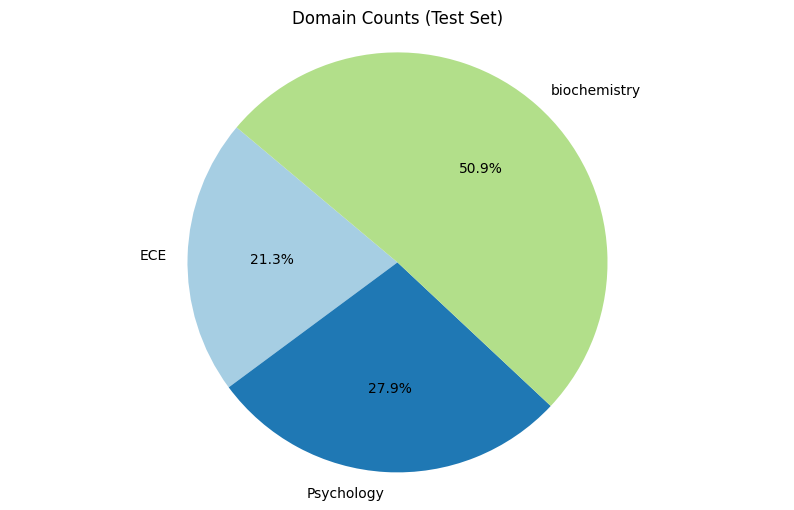

The domain ECE has 244 records in the test set.
The domain Psychology has 320 records in the test set.
The domain biochemistry has 584 records in the test set.


In [16]:
labels = np.unique(domainsTest, return_counts=True)[0]
labelCounts =  np.unique(domainsTest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTest)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Test Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the test set.")

In [17]:
abstractsVal = val_data[:,3]
keywordsVal = val_data[:,2]
domainsVal = val_data[:,1]
allLabelsVal = val_data[:,0]

print("Number of abstracts: ",len(abstractsVal))
print("Shape of abstracts: ",np.shape(abstractsVal))
print("Number of keywords: ",len(keywordsVal))
print("Shape of keywords: ",np.shape(keywordsVal))
print("Number of domains: ",len(domainsVal))
print("Shape of domains: ",np.shape(domainsVal))
print("Number of labels: ",len(allLabelsVal))
print("Shape of labels: ",np.shape(allLabelsVal))

print(abstractsVal[0:2])
print(keywordsVal[0:2])
print(domainsVal[0:2])
print(allLabelsVal[0:2])

Number of abstracts:  230
Shape of abstracts:  (230,)
Number of keywords:  230
Shape of keywords:  (230,)
Number of domains:  230
Shape of domains:  (230,)
Number of labels:  230
Shape of labels:  (230,)
['background invasive meningococcal disease imd incidence increased in quebec starting in 2003 and was caused by a serogroup b sequence type 269 clone the saguenaylacsaintjean slsj region was particularly affected with a rate of 34 per 100 000 personyears in 20062013 in may 2014 an immunization campaign was launched in slsj using the 4component proteinbased meningococcal vaccine menb4c we aimed to evaluate the impact of the campaign 2 years after its initiation methods immunization registry data and serogroup b invasive meningococcal disease bimd cases notified to public health authorities and confirmed by culture or polymerase chain reaction from july 1996 to december 2016 were analyzed including a multivariate poisson regression model of incidence rates results by the end of the camp

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [ 47  71 112]


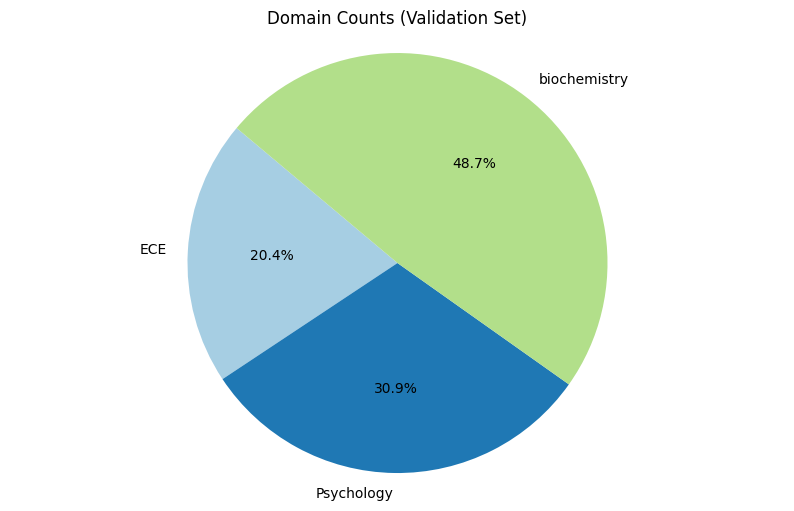

The domain ECE has 47 records in the vaidation set.
The domain Psychology has 71 records in the vaidation set.
The domain biochemistry has 112 records in the vaidation set.


In [18]:
labels = np.unique(domainsVal, return_counts=True)[0]
labelCounts =  np.unique(domainsVal, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsVal)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Validation Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the vaidation set.")

In [19]:
# Function to tokenize and encode the dataset
def encode_data(data, tokenizer, max_length=128):
    # print(len(data[:,2]))
    inputs = tokenizer(
        data[:,3].tolist(), # abstract
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    # print(len(dataShuffled[:, 0]))
    labels = torch.tensor(data[:, 0].astype(int))
    print("Label length ", len(labels))
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [20]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))


(4588, 4)
(1148, 4)
(230, 4)


In [21]:
# Encode training, validation, and testing data
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)



# Data loaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

Label length  4588
Label length  230
Label length  1148


In [22]:
print(np.unique(train_data[:,0]))

['0' '1' '2']


In [23]:
# Load SciBERT model
print(len(np.unique(train_data[:,0])))
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(np.unique(train_data[:,0])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

3


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [24]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [25]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 20
num_warmup_steps = 1e-4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [27]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    # Training
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch


        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    predictions = []
    true_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

    val_micro_f1 = calculate_metrics('val', predictions, true_labels)
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss}")
    print(f"  Val Micro F1: {val_micro_f1}")
    print(f"  Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Epoch 1/20: 100%|██████████| 144/144 [01:31<00:00,  1.57batch/s]


Epoch 1/20
  Train Loss: 0.3391011112835258
  Val Micro F1: 0.9652173913043478
  Time: 1m 33s


Epoch 2/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 2/20
  Train Loss: 0.09626991716019499
  Val Micro F1: 0.9652173913043478
  Time: 1m 43s


Epoch 3/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 3/20
  Train Loss: 0.047965413433202125
  Val Micro F1: 0.9782608695652174
  Time: 1m 43s


Epoch 4/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 4/20
  Train Loss: 0.02322025409133251
  Val Micro F1: 0.9739130434782609
  Time: 1m 43s


Epoch 5/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 5/20
  Train Loss: 0.01259628910863992
  Val Micro F1: 0.9608695652173913
  Time: 1m 43s


Epoch 6/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 6/20
  Train Loss: 0.006508259394953105
  Val Micro F1: 0.9652173913043478
  Time: 1m 43s


Epoch 7/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 7/20
  Train Loss: 0.0017296961757690748
  Val Micro F1: 0.9652173913043478
  Time: 1m 43s


Epoch 8/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 8/20
  Train Loss: 0.0015420057671791357
  Val Micro F1: 0.9695652173913043
  Time: 1m 43s


Epoch 9/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 9/20
  Train Loss: 0.0007855411226450491
  Val Micro F1: 0.9652173913043478
  Time: 1m 43s


Epoch 10/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 10/20
  Train Loss: 0.0009861112482920159
  Val Micro F1: 0.9695652173913043
  Time: 1m 43s


Epoch 11/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 11/20
  Train Loss: 0.0002676571748452261
  Val Micro F1: 0.9695652173913043
  Time: 1m 43s


Epoch 12/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 12/20
  Train Loss: 0.00023875924398453208
  Val Micro F1: 0.9695652173913043
  Time: 1m 43s


Epoch 13/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 13/20
  Train Loss: 0.00019064393422417602
  Val Micro F1: 0.9695652173913043
  Time: 1m 43s


Epoch 14/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 14/20
  Train Loss: 0.00017719495665207633
  Val Micro F1: 0.9695652173913043
  Time: 1m 43s


Epoch 15/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 15/20
  Train Loss: 0.00016194338574374947
  Val Micro F1: 0.9695652173913043
  Time: 1m 43s


Epoch 16/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 16/20
  Train Loss: 0.00016795882791282365
  Val Micro F1: 0.9695652173913043
  Time: 1m 43s


Epoch 17/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 17/20
  Train Loss: 0.0001414465492012419
  Val Micro F1: 0.9695652173913043
  Time: 1m 43s


Epoch 18/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 18/20
  Train Loss: 0.00013808094399792026
  Val Micro F1: 0.9695652173913043
  Time: 1m 43s


Epoch 19/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 19/20
  Train Loss: 0.00013079222475830142
  Val Micro F1: 0.9695652173913043
  Time: 1m 43s


Epoch 20/20: 100%|██████████| 144/144 [01:41<00:00,  1.42batch/s]


Epoch 20/20
  Train Loss: 0.00013016799903198262
  Val Micro F1: 0.9695652173913043
  Time: 1m 43s


In [28]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[236   4   4]
 [  6 302  12]
 [  3  15 566]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       244
           1       0.94      0.94      0.94       320
           2       0.97      0.97      0.97       584

    accuracy                           0.96      1148
   macro avg       0.96      0.96      0.96      1148
weighted avg       0.96      0.96      0.96      1148

Macro F1 Score: 0.9594511150687391
Micro F1 Score: 0.9616724738675958
Weighted F1 Score: 0.961687355442342
Macro Precision: 0.9588612886783644
Micro Precision: 0.9616724738675958
Weighted Precision: 0.9617081375497916
Macro Recall: 0.9600470656486264
Micro Recall: 0.9616724738675958
Weighted Recall: 0.9616724738675958


In [29]:
model.save_pretrained('/content/drive/MyDrive/WoS/BERT_WoS_Abstracts_5736')